In [8]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import asyncio
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [20]:

api = wandb.Api()
entity, project = "ajzero", "AlphaZero"
x_metric = "compute_budget"
tag = x_metric
runs = api.runs(entity + "/" + project, filters={"tags": {"$in": [tag]}})
runs

<Runs ajzero/AlphaZero>

In [21]:
# crete a dataframe from runs and summary metrics

data = []
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config
    summary.update(config)
    data.append(summary)

df = pd.DataFrame(data)

df


100%|██████████| 45/45 [00:00<00:00, 75770.24it/s]


,Self_Play/Max_Reward,Self_Play/Min_Reward,Self_Play/Total_Timesteps,Self_Play/Total_Average_Reward,Training/Value_loss,Self_Play/EMA_Reward,max_max_reward_step,Training/Learning_Rate,Self_Play/Cumulative_Reward,Self_Play/Runtime_per_Timestep,...,expansion_policy,n_steps_learning,selection_policy,value_loss_weight,max_episode_length,policy_loss_weight,sample_batch_ratio,regularization_weight,tree_evaluation_policy,replay_buffer_multiplier
0,-13,-13,104,-96.325000,1.583231,-23.830414,8,0.001,-1444.875,5048.192308,...,fromprior,1,PolicyPUCT,1,200,30,1,0.0001,minimal_variance_constraint,10
1,-20,-48,207,-93.316667,0.835691,-34.721415,8,0.001,-1399.750,3836.077295,...,fromprior,1,PUCT,1,200,30,1,0.0001,minimal_variance_constraint,10
2,-17,-20,143,-128.425000,2.080371,-42.971919,14,0.001,-1926.375,5203.020979,...,fromprior,1,PUCT,1,200,30,1,0.0001,default,10
3,-13,-18,114,-74.933333,1.940431,-19.535653,7,0.001,-1124.000,371.570175,...,fromprior,1,PolicyPUCT,1,200,30,1,0.0001,minimal_variance_constraint,10
4,-17,-21,148,-138.366667,3.095002,-52.765814,12,0.001,-2075.500,483.621622,...,fromprior,1,PUCT,1,200,30,1,0.0001,minimal_variance_constraint,10
5,-17,-20,148,-127.108333,3.795451,-45.140475,14,0.001,-1906.625,5539.040541,...,fromprior,1,PUCT,1,200,30,1,0.0001,default,10
6,-13,-19,126,-76.058333,0.653887,-20.705343,7,0.001,-1140.875,842.896825,...,fromprior,1,PolicyPUCT,1,200,30,1,0.0001,minimal_variance_constraint,10
7,-19,-32,203,-105.333333,0.641601,-36.008529,11,0.001,-1580.000,3193.807882,...,fromprior,1,PUCT,1,200,30,1,0.0001,minimal_variance_constraint,10
8,-17,-135,195,-133.658333,27.356403,-52.573190,13,0.001,-2004.875,4333.569231,...,fromprior,1,PUCT,1,200,30,1,0.0001,default,10
9,-13,-15,108,-82.166667,2.146777,-21.011683,7,0.001,-1232.500,2109.824074,...,fromprior,1,PolicyPUCT,1,200,30,1,0.0001,minimal_variance_constraint,10


In [22]:
df.columns

Index(['Self_Play/Max_Reward', 'Self_Play/Min_Reward',
       'Self_Play/Total_Timesteps', 'Self_Play/Total_Average_Reward',
       'Training/Value_loss', 'Self_Play/EMA_Reward', 'max_max_reward_step',
       'Training/Learning_Rate', 'Self_Play/Cumulative_Reward',
       'Self_Play/Runtime_per_Timestep', 'max_Max_Reward',
       'Self_Play/Entropies', 'Self_Play/Reward_STD',
       'Training/Regularization_loss', 'Training/Value_and_Policy_loss',
       'max_Mean_Reward', 'max_reward_step', 'Self_Play/Timesteps',
       'Self_Play/Mean_Reward', 'Self_Play/Mean_Entropy',
       'Self_Play/Mean_Timesteps', '_step', '_wandb',
       'Self_Play/Timesteps_STD', 'Training/Value_Simularities', '_timestamp',
       'Self_Play/Min_Timesteps', 'Training/Replay_Buffer_Size',
       'Training/Policy_loss', 'Self_Play/Total_Runtime', '_runtime',
       'Self_Play/Rewards', 'env_id', 'layers', 'puct_c', 'lr_gamma',
       'eval_param', 'hidden_dim', 'iterations', 'model_type', 'norm_layer',
       

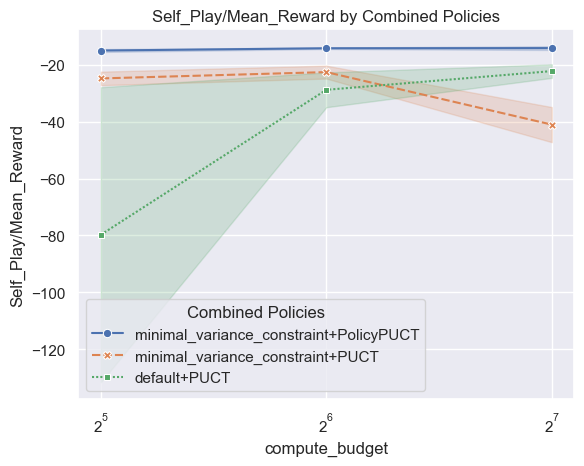

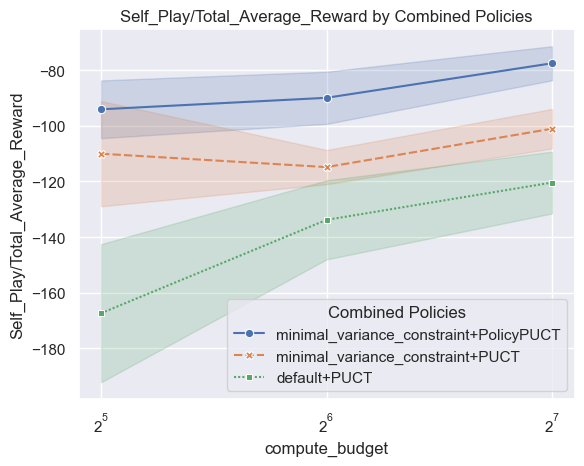

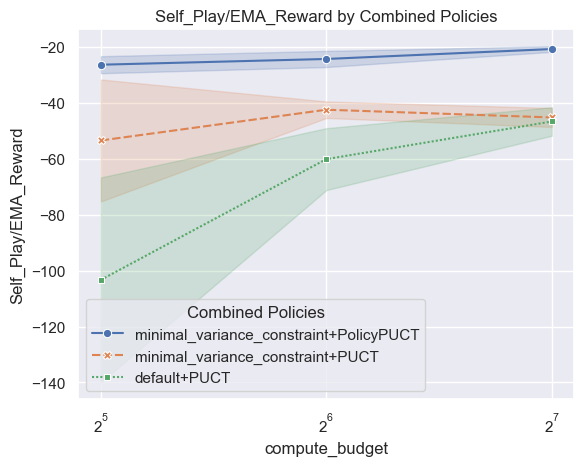

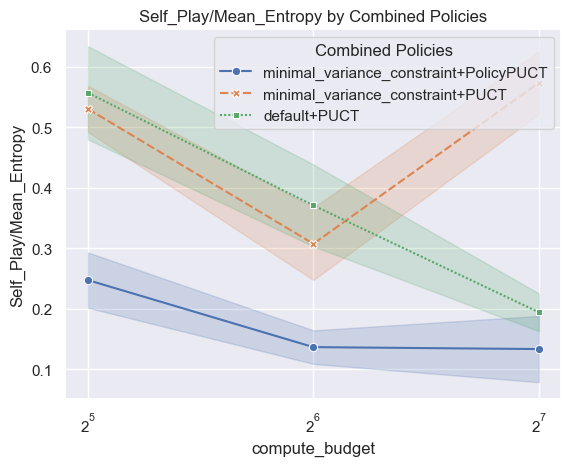

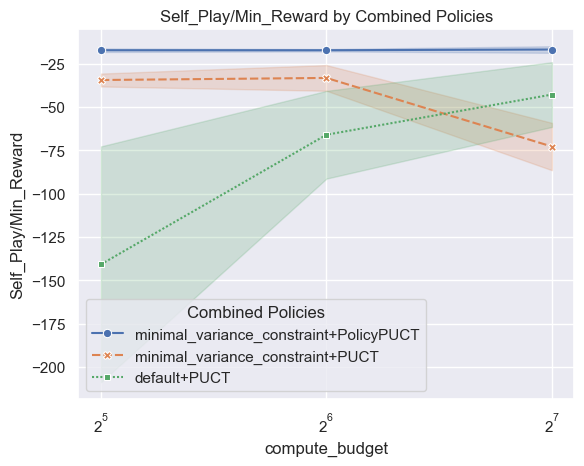

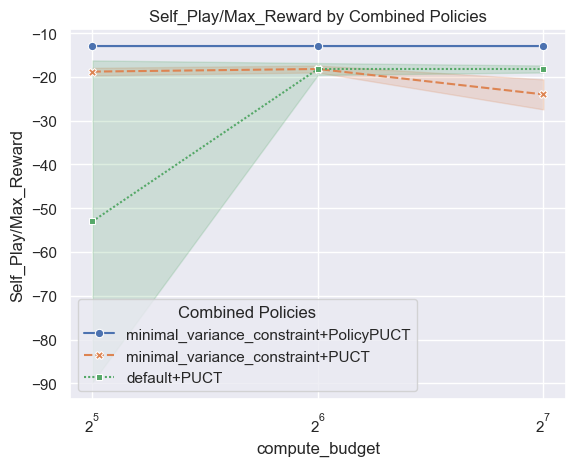

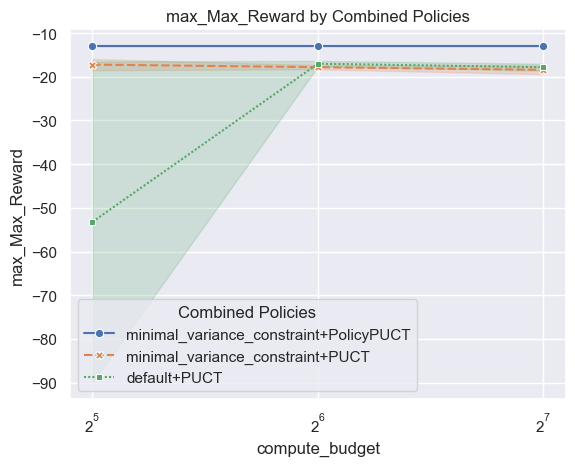

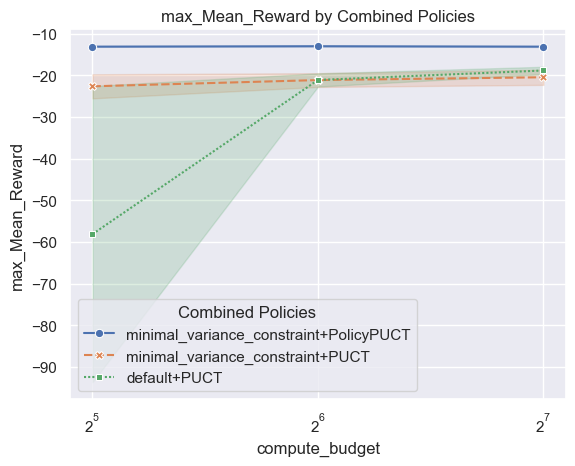

In [26]:


df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']

metrics = ['Self_Play/Mean_Reward', "Self_Play/Total_Average_Reward", "Self_Play/EMA_Reward", 'Self_Play/Mean_Entropy', 'Self_Play/Min_Reward',
           'Self_Play/Max_Reward', 'max_Max_Reward', 'max_Mean_Reward']

for metric in metrics:
    sns.set_theme(style="darkgrid")

    # Create a line plot with confidence intervals
    sns.lineplot(data=df, x=x_metric, y=metric,
                hue="policy_combination", style="policy_combination",
                markers=True, errorbar="se", estimator=np.mean)

    # Customize the plot with titles and labels
    plt.title(f'{metric} by Combined Policies')
    plt.xlabel(x_metric)  # Replace with actual x-axis label
    plt.ylabel(metric)
    plt.legend(title='Combined Policies')
    plt.gca().set_xscale('log', base=2)

    # Show the plot
    plt.show()
